In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
from typing import NamedTuple

## Self-defined ConvLSTM Layer

default parameter initialization by pytorch is used

reference: https://github.com/automan000/Convolutional_LSTM_PyTorch/blob/master/convolution_lstm.py#L15

In [2]:
#Original ConvLSTM Paper with extra terms
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super().__init__()
        assert hidden_channels % 2 == 0
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 5#check this one
        self.padding = (kernel_size - 1)//2
        
        self.Wxi = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Whi = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wxf = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Whf = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wxc = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Whc = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wxo = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Who = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wci = None
        self.Wcf = None
        self.Wco = None
        
    def forward(self, x, h, c):
        #x_t, h_(t-1), c_(t-1)
        i_t = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c*self.Wci)
        f_t = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c*self.Wcf)
        c_t = f_t*c + i_t*torch.tanh(self.Wxc(x) + self.Whc(h))
        o_t = torch.sigmoid(self.Wxo(x) + self.Who(h) + c_t*self.Wco)
        h_t = o_t*torch.tanh(c_t)
        return h_t, c_t
    def init_hidden(self, batch_size, hidden, size):
        self.Wci = nn.Parameter(torch.zeros(1, hidden, size))
        self.Wcf = nn.Parameter(torch.zeros(1, hidden, size))
        self.Wco = nn.Parameter(torch.zeros(1, hidden, size))
        return (torch.zeros(batch_size, hidden, size), torch.zeros(batch_size, hidden, size))
        
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, step = 1, effective_step = [1]):
        super().__init__()
        self.channels = [input_channels] + hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = "cell{}".format(i)
            cell = ConvLSTMCell(self.channels[i], self.channels[i+1], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)
    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                name = "cell{}".format(i)
                if step == 0:
                    bsize,_,size = x.size()
                    h,c = getattr(self, name).init_hidden(batch_size = bsize, hidden = self.channels[i+1], size = size)
                    internal_state.append((h,c))
                h,c = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = x, new_c
            if step in self.effective_step:
                outputs.append(x)
        return x

## Hyperparameters
evaluating 10 quantiles, using 10000 data for training, 3000 for validation and the rest for testing (yet to be done)

the remaining hyperparameters are tuned for good performance

In [3]:
#Config Parameters
quantiles = [0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95]

q40index = quantiles.index(0.4)+1
q60index = quantiles.index(0.6)+1
qlen = len(quantiles)
i_train = 10000
i_val = i_train + 3000
i_test = i_val + 6000

batch_size, lr, n_epochs, num_iter = 128, 0.0001, 60, 1
lag_period, num_features, forecast_horizon = 60, 9, 2
num_inputs, num_outputs, num_hidden = lag_period, 1+qlen, 40
dropout= 0.1
kernel_size = 5
steps = 1

## Load Data
crypto_data.csv compiles all the data on the repo

first column (date) is excluded from computation

In [4]:
#Load & Split Data
data = np.array(pd.read_csv("crypto_data.csv"))[:,1:].astype("float32")
alldata = np.array([data[i+1]/data[i]-1 for i in range(len(data)-1)])

torch.set_default_dtype(torch.float32)
X = torch.tensor(np.array([alldata[i-lag_period:i] for i in range(lag_period, len(alldata))]))
Y = alldata[lag_period+forecast_horizon:]

## Split Data
data is split using the indices from hyperparameters

In [5]:
X_train, Y_train = X[:i_train], torch.tensor(Y[:i_train])
X_val, Y_val = X[i_train:i_val], Y[i_train:i_val]
X_test, Y_test = X[i_val:i_test], Y[i_val:i_test]
train_iter = torch.utils.data.DataLoader(list(zip(X_train,Y_train)), batch_size=batch_size, shuffle = True)
val_iter = torch.utils.data.DataLoader(list(zip(X_val,Y_val)), batch_size=batch_size, shuffle = False)

## Evaluation & Loss Functions (per sample)
The functions below are defined such that hopefully, they could be used in both MLP and ConvLSTM implementations.
For the inputs to these functions, they are defined as follows:
1. $\hat{y}$: prediction with shape (sample size)  x (outputs = 1 mean + 10 quantiles) x (no. of features = 9)
2. $y$: observation with shape (sample size) x (no. of features = 9), corresponds to Y_'s in the cell above
3. $\tau$: quantile vector of length (J=10)

$y$ and $\hat{y}$ are tensors for loss function and numpy array for evaluation functions.
<br>
### Loss Function
As defined in the paper, the loss function is the sum of mean squared errors and tilted loss. The for loop computes the 2nd summation.
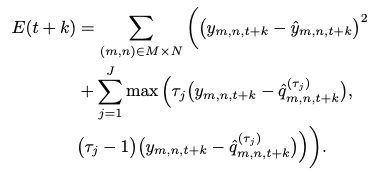

In [6]:
#Evaluation & Loss Functions
def lossfn(τ, y, ŷ):
    loss = torch.mean(torch.square(y-ŷ[:,0,:]))
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,i+1,:]
        loss += torch.mean(q*r - r*(r<0))
#     loss /= y.shape[0]
    return loss

### Tilted Loss
Similar to the 2nd summation in loss function. Tilted loss is evaluated on quantiles only which is why the 2nd index (i+1) ranges from 1 to 10 for $\hat{y}$.
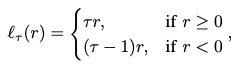

In [7]:
#for evaluation: remember to turn tensors into np.array()
def tilted_loss(τ, y, ŷ):
    loss = 0.0
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,i+1,:]
        loss += np.mean(q*r - r*(r<0))
#     loss /= y.shape[0]
    return loss

### Crossing Loss & Number of Crosses
Crossing loss and number of crosses are evaluated on neighbouring quantiles only which is why we have the 2nd indices of (i+1) and (i+2) (same reason as tilted loss) and for loop range of (11-2=9) for 10 quantiles.
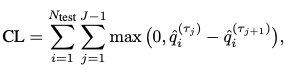

In [8]:
def crossing_loss(ŷ):
    loss = 0.0 #crossing loss as defined in the paper
    num_cross = 0.0
    for i in range(ŷ.shape[1]-2):
        q = ŷ[:,i+1,:] - ŷ[:,i+2,:]
        loss += np.sum(np.maximum(q,0))
        num_cross += np.sum(q>0)
    loss /= ŷ.shape[0]*(ŷ.shape[1]-2)
    num_cross /= ŷ.shape[0]
    return loss, num_cross

### Interval Coverage Percentage (ICP) & Mean Interval Length (MIL)
ICP: the fraction of observations (y) that are within the prediction interval
<br>MIL: the average length of the prediction interval
<br> (lower , upper) is the corresponding pair of predicted quantiles e.g. 5% and 95% quantiles, 10% and 90% quanatiles etc

In [9]:
def eval_quantiles(lower, upper, y):
    icp = np.mean((y > lower) & (y < upper))
    mil = np.mean(np.maximum(0,upper-lower))
    return icp,mil

### Errors (MSE, RMSE, MAE)
Standard error functions evaluated on predicted means only. Therefore, the 2nd index for $\hat{y}$ is 0

correct_sign computes the fraction of predictions that gets the sign correctly

In [10]:
def eval_error(y, ŷ):
    r = np.abs(y-ŷ[:,0,:])
    mse = np.mean(r*r)
    rmse = np.sqrt(mse)
    mae = np.mean(r)
    correct_sign = np.mean(y*ŷ[:,0,:]<0)/(1-np.mean(y*ŷ[:,0,:]==0))
    return mse, rmse, mae, correct_sign

### Checking Quantiles
1. determines the quality of quantiles (mainly for 40% and 60% quantiles)
2. determines % of time where we will execute trades
3. determines % of trades executed that are profitable

In [11]:
def check_quantiles(y,ŷ,i_low,i_high):
    print("True values are:")
    #1.
    print("above 40% quantiles:",np.mean(y > ŷ[:,i_low,:]))
    print("below 60% quantiles:",np.mean(y < ŷ[:,i_high,:]))
    #2.
    print("40% quantiles positive:",np.mean(ŷ[:,i_low,:]>0))
    print("60% quantiles negative:",np.mean(ŷ[:,i_high,:]<0))
    #3.
    print("profitable with 40% quantiles:", np.mean([[ŷ[i,i_low,j]>0 and y[i,j]>0 for i in range(i_val-i_train)] for j in range(num_features)])/np.mean(ŷ[:,i_low,:]>0))
    print("profitable with 60% quantiles:", np.mean([[ŷ[i,i_high,j]<0 and y[i,j]<0 for i in range(i_val-i_train)] for j in range(num_features)])/np.mean(ŷ[:,i_high,:]<0))

## Model Initialization
on top of ConvLSTM, there's a final output layer which, according to DeepJMQR's author, is equivalent to a 1x1 linear convolutional layer
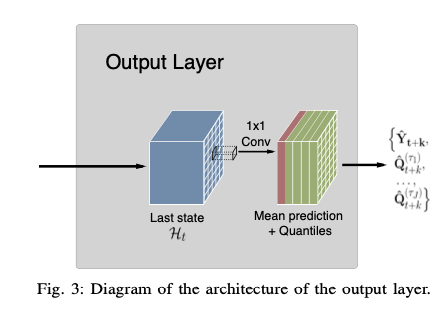

In [12]:
def init():
    net = nn.Sequential(nn.BatchNorm1d(num_inputs, affine = False),
                        ConvLSTM(num_inputs, [num_hidden], kernel_size, step=steps, effective_step=[steps]),
                        nn.Dropout1d(dropout),
                        nn.Conv1d(num_hidden, num_outputs, 1, bias = True))
    return net

### Train 
inputs data into the model to make predictions, evaluates loss value and makes adjustment to parameters, then returns loss value

Reference: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

"The Training Loop" & "Per-Epoch Activity"

In [13]:
#Train Model
def train(model, train_iter, quantiles, loss_fn, optimizer, num_epochs = 100):
    running_loss = 0
    last_loss = 0
    for i, data in enumerate(train_iter):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(quantiles, labels, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        last_loss = loss.item()
    return last_loss


### Iteration & Validation
trains the model, validates on validation data, saves the best performing model and returns the prediction using the best model

In [14]:
def iter():
    animator = d2l.Animator(xlabel = "epoch", ylabel = "loss", xlim = [1,n_epochs], legend = ["train", "val"])
    best_vloss = 1e9
    for epoch in range(n_epochs):
        net.train(True)
        avg_loss = train(net, train_iter, quantiles, lossfn, optimizer, num_epochs = n_epochs)
        net.train(False)
        running_vloss = 0.0
        for i, vdata in enumerate(val_iter):
            vinputs, vlabels = vdata
            voutputs =  net(vinputs)
            vloss = lossfn(quantiles, vlabels, voutputs)
            running_vloss += vloss
        avg_vloss = float(running_vloss / (i+1))
#         if epoch % (n_epochs/20) == 0:
        animator.add(epoch+1, (avg_loss, avg_vloss))
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(net, "model_best_state_ConvLSTM")
    model = torch.load("model_best_state_ConvLSTM")
    pred = model(X_val).detach().numpy()
    return pred

## Reiterate & Evaluate Errors

... finished running iter 1


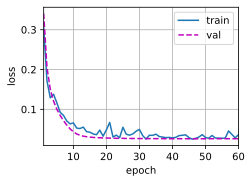

In [15]:
#Iterate 
cl,tl,err,icp,mil = [],[],[],[[] for _ in range(qlen//2)],[[] for _ in range(qlen//2)]
for k in range(num_iter):
    net = init()
    optimizer = torch.optim.RMSprop(net.parameters(), lr = lr)
    pred = iter()
    cl.append(crossing_loss(pred))
    tl.append(tilted_loss(quantiles,Y_val,pred))
    err.append(eval_error(Y_val,pred))
    print("... finished running iter",k+1)
    for i in range(qlen//2):
        t1,t2 = eval_quantiles(pred[:,i+1,:],pred[:,qlen-i,:],Y_val)
        icp[i].append(t1)
        mil[i].append(t2)

In [16]:
#Evaluate Errors
def print_error(cl, tl, err, icp, mil):
    print("Crossing Loss:", np.mean([y[0] for y in cl]), ", Number of Crosses:", np.mean([y[1] for y in cl]))
    print("MSE:",np.mean([y[0] for y in err]), "RMSE:", np.mean([y[1] for y in err]),"MAE:", np.mean([y[2] for y in err]))
    print("Tilted loss:", np.mean(tl))
    print("Prediction Intervals:")
    for i in range(qlen//2):
        print(round((quantiles[qlen-i-1]-quantiles[i])*100),"% ICP & MIL:",round(np.mean(icp[i]),6),round(np.mean(mil[i]),6))
    print("the model predicts the sign correctly in ", round(np.mean([y[3] for y in err])*100,6),"% of the cases (not including 0)")

In [17]:
print_error(cl, tl, err, icp, mil)

Crossing Loss: 3.751681234549593e-05 , Number of Crosses: 0.18866666666666668
MSE: 0.0001388794 RMSE: 0.011784711 MAE: 0.00750394
Tilted loss: 0.02585861354600638
Prediction Intervals:
90 % ICP & MIL: 0.92463 0.036432
80 % ICP & MIL: 0.842704 0.025425
60 % ICP & MIL: 0.644 0.014713
40 % ICP & MIL: 0.455741 0.009053
20 % ICP & MIL: 0.241 0.004528
the model predicts the sign correctly in  48.867398 % of the cases (not including 0)


### Some Observations
1. it could be observed that the 40% and 60% quantiles are roughly at the right position
2. the total times we trade is quite little (3% and 1% for 40 and 60% quantiles respectively)
3. the probability of profit is over 50% for both quantiles

In [18]:
check_quantiles(Y_val,pred,q40index,q60index)

True values are:
above 40% quantiles: 0.608037037037037
below 60% quantiles: 0.632962962962963
40% quantiles positive: 0.03459259259259259
60% quantiles negative: 0.010962962962962963
profitable with 40% quantiles: 0.5342612419700214
profitable with 60% quantiles: 0.5641891891891891


observe that the predicted quantiles are able to capture the change in variance for the true return value

<AxesSubplot:>

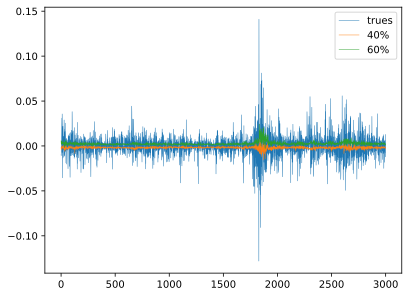

In [19]:
sec = 0
#change sec to values between 0 and 8 to view prediction performance of other securities
istart, iend = 0, i_val-i_train
df = pd.DataFrame(np.vstack((Y_val[istart:iend,sec],pred[istart:iend,q40index,sec],pred[istart:iend,q60index,sec])).transpose(), columns = ["trues","40%","60%"])
df.plot(lw=0.5)